In [33]:
from IPython.display import Image as IPImage, Markdown, display
from transformers import BitsAndBytesConfig
from PIL import Image, ImageDraw
import torch

In [2]:
model_variant = "medgemma-1.5-4b-it"  # @param ["medgemma-1.5-4b-it", "medgemma-4b-it", "medgemma-27b-it", "medgemma-27b-text-it"]
model_id = f"google/{model_variant}"

In [3]:
from transformers import pipeline

In [5]:
pipe = pipeline("image-text-to-text", model=model_id)

Loading weights: 100%|██████████| 883/883 [00:00<00:00, 1457.33it/s, Materializing param=model.vision_tower.vision_model.post_layernorm.weight]                      
The image processor of type `Gemma3ImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


In [38]:
system_instruction = "You are an expert dentist. Be as brief as possible and present your diagnosis."
prompt = "The image is close up X-Ray of a few teeth. What are the bounding box coordinates of the teeth? The coordinates should be of the format x1,y1,x2,y2. The image is of size -> (768, 574)"
image = Image.open("individual_x_ray_dataset/extraction_img9.jpg")
max_new_tokens = 300

messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": system_instruction}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt},
            {"type": "image", "image": image}
        ]
    }
]

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
Both `max_new_tokens` (=300) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


---

**[ User ]**

The image is close up X-Ray of a few teeth. What are the bounding box coordinates of the teeth? The coordinates should be of the format x1,y1,x2,y2. The image is of size -> (768, 574)

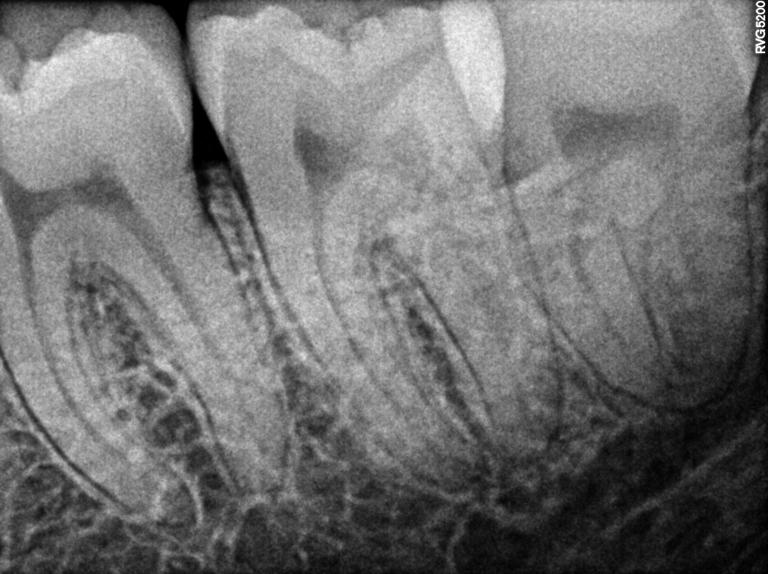

---

**[ MedGemma ]**

Based on the image, the bounding box coordinates for the teeth are approximately:

*   **Tooth 1 (Top):** x1=150, y1=200, x2=450, y2=500
*   **Tooth 2 (Middle):** x1=300, y1=210, x2=500, y2=500
*   **Tooth 3 (Bottom):** x1=200, y1=300, x2=500, y2=500

These coordinates represent the approximate rectangular region encompassing the visible portions of the teeth in the image.

---

In [39]:
output = pipe(text=messages, max_new_tokens=max_new_tokens, do_sample=False)
response = output[0]["generated_text"][-1]["content"]

display(Markdown(f"---\n\n**[ User ]**\n\n{prompt}"))
display(image)
display(Markdown(f"---\n\n**[ MedGemma ]**\n\n{response}\n\n---"))

In [40]:
annotation = Image.open("individual_x_ray_dataset/extraction_img9.jpg")

In [41]:
def annotate(image, boxes, labels=None):
    """
    Draw boxes on image.
    
    image: PIL Image
    boxes: list of (x1, y1, x2, y2) tuples
    labels: optional list of strings
    
    Returns: PIL Image with boxes drawn
    """
    img = image.copy()
    draw = ImageDraw.Draw(img)
    
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        
        if labels and i < len(labels):
            draw.text((x1, y1-15), labels[i], fill="red")
    
    return img

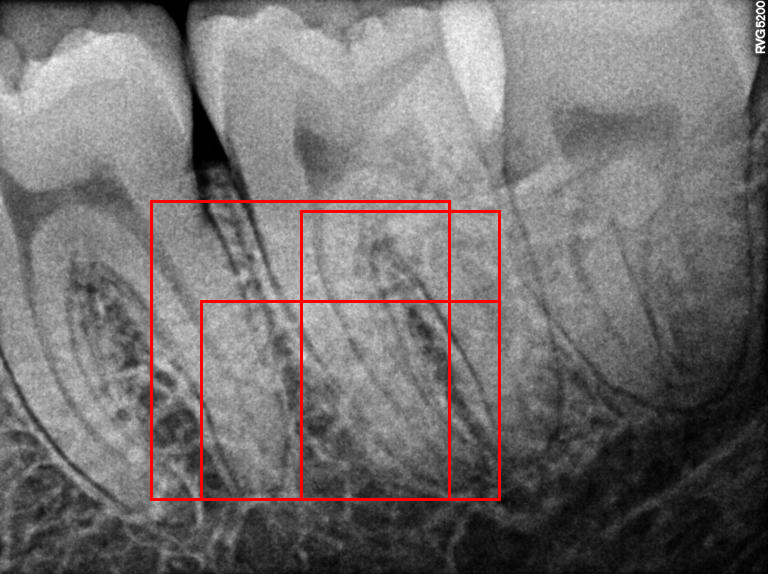

In [43]:
annotate(annotation,[(150, 200, 450, 500),(300, 210, 500, 500),(200, 300, 500, 500)])